# 不斉触媒の重回帰分析

https://mfa-catalysis.com/asymmetric_catalysis_physorg/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

## 不斉触媒反応における自由エネルギー関係（回帰分析）

"Multidimensional steric parameters in the analysis of asymmetric catalytic reactions"
Harper, K., Bess, E. & Sigman, M., Nature Chem 4, 366–374 (2012).

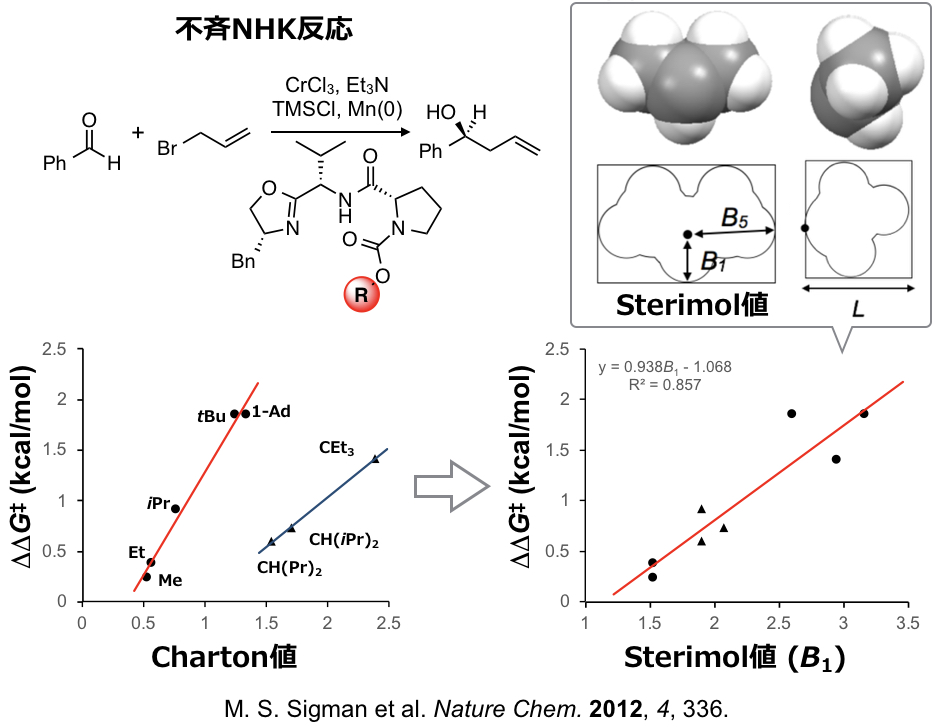

"Prediction of Catalyst and Substrate Performance in the Enantioselective Propargylation of Aliphatic Ketones by a Multidimensional Model of Steric Effects", Kaid C. Harper, Sarah C. Vilardi, and Matthew S. Sigman*, J. Am. Chem. Soc. 2013, 135, 7, 2482–2485

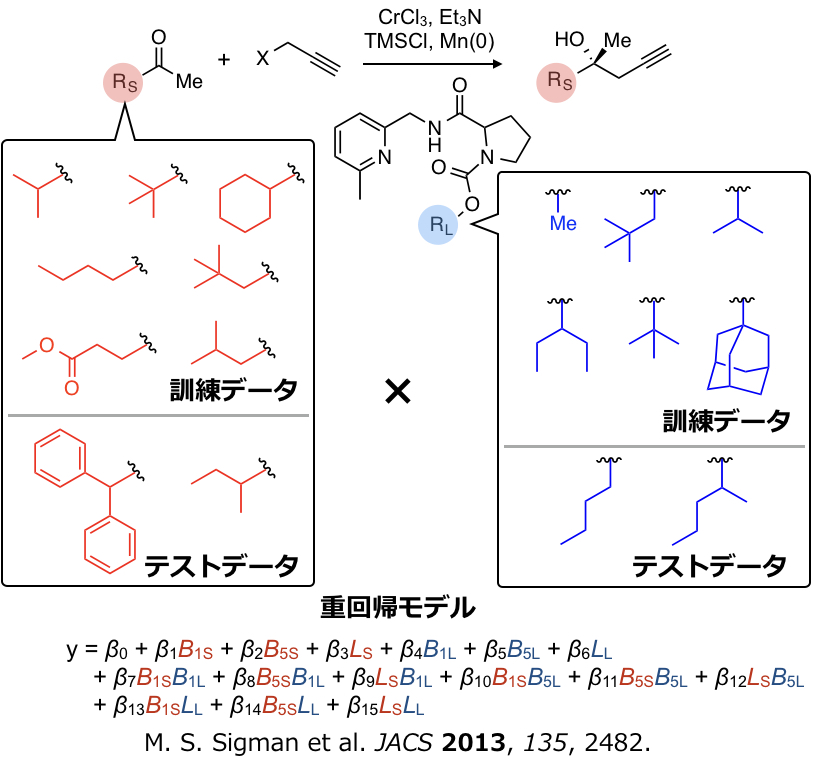


In [2]:
# データの読み込み

data_file_path = './MFA_Introduction-main/6th/data'

# 目的変数
y_column = ['substituent_pairs', 'ΔΔG(kcal/mol)'] #ヘッダーがないため追加する
y_training_origin = pd.read_csv(f'{data_file_path}/NHK_training.txt',
                          delimiter='\t',
                          header=None,
                          names=y_column)
y_test_origin = pd.read_csv(f'{data_file_path}/NHK_test.txt',
                        delimiter='\t',
                        header=None,
                        names=y_column)

# 説明変数
x_training_origin = pd.read_csv(f'{data_file_path}/NHK_descriptor.txt',
                          delimiter='\t')
x_test_origin = pd.read_csv(f'{data_file_path}/NHK_test_descriptor.txt',
                      delimiter='\t')

# 置換基の列名を目的変数のデータと合わせる
x_training_origin = x_training_origin.rename(columns={'Unnamed: 0': 'substituent_pairs'})
x_test_origin = x_test_origin.rename(columns={'Unnamed: 0': 'substituent_pairs'})

In [3]:
# 説明変数トレーニングデータの基本統計量
display(x_training_origin.describe())

print()
x_training_origin.head()

,B1L,B5L,LL,B1S,B5S,LS,B1LB1S,B1LB5S,B1LLS,B5LB1S,B5LB5S,B1LLS.1,LLB1S,LLB5S,LLLS
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.338333,3.723333,4.576667,2.132000,3.910000,5.464000,4.985333,9.14300,12.776333,7.938000,14.558333,12.776333,9.757667,17.894667,25.007667
std,0.661279,0.869397,1.089949,0.449754,0.570916,0.984023,1.782833,2.93332,4.331346,2.527394,4.038302,4.331346,3.141205,5.036138,7.540946
min,1.700000,2.230000,2.950000,1.730000,3.360000,4.340000,2.940000,5.71000,7.380000,3.860000,7.490000,7.380000,5.100000,9.910000,12.800000
25%,1.710000,3.340000,4.250000,1.750000,3.370000,4.390000,3.612500,6.99500,9.367500,6.265000,11.837500,9.367500,7.547500,14.590000,19.060000
50%,2.095000,3.675000,4.345000,2.100000,3.650000,5.540000,4.505000,7.87500,11.605000,7.770000,15.315000,11.605000,9.080000,16.955000,24.070000
75%,3.020000,4.650000,5.040000,2.130000,4.550000,6.470000,6.052500,10.81000,14.605000,9.830000,16.792500,14.605000,11.397500,20.087500,28.505000
max,3.410000,4.770000,6.530000,2.950000,4.620000,6.580000,10.060000,15.75000,22.440000,14.070000,22.040000,22.440000,19.260000,30.170000,42.970000


,substituent_pairs,B1L,B5L,LL,B1S,B5S,LS,B1LB1S,B1LB5S,B1LLS,B5LB1S,B5LB5S,B1LLS.1,LLB1S,LLB5S,LLLS
0,Me_nBu,1.70,2.23,2.95,1.73,4.62,6.58,2.94,7.85,11.19,3.86,10.30,11.19,5.10,13.63,19.41
1,CH2tBu_nBu,1.71,4.65,5.04,1.73,4.62,6.58,2.96,7.90,11.25,8.04,21.48,11.25,8.72,23.28,33.16
2,iPr_nBu,2.06,3.34,4.25,1.73,4.62,6.58,3.56,9.52,13.55,5.78,15.43,13.55,7.35,19.64,27.97
3,3pentyl_nBu,2.13,4.77,4.34,1.73,4.62,6.58,3.68,9.84,14.02,8.25,22.04,14.02,7.51,20.05,28.56
4,tBu_nBu,3.02,3.52,4.35,1.73,4.62,6.58,5.22,13.95,19.87,6.09,16.26,19.87,7.53,20.10,28.62


In [4]:
# 目的変数トレーニングデータの基本統計量
display(y_training_origin.describe())

print()
y_training_origin.head()

,ΔΔG(kcal/mol)
count,30.000000
mean,1.094800
std,0.462012
min,0.405000
25%,0.758500
50%,1.038000
75%,1.485750
max,1.982000


,substituent_pairs,ΔΔG(kcal/mol)
0,Me_nBu,0.442
1,CH2tBu_nBu,0.405
2,iPr_nBu,0.530
3,3pentyl_nBu,0.447
4,tBu_nBu,1.044


### 重回帰分析



In [5]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

In [6]:
# 一旦トレーニングデータとテストデータを合わせる
X = pd.concat([x_training_origin, x_test_origin]).reset_index().drop(columns=['index', 'substituent_pairs'])
y = pd.concat([y_training_origin, y_test_origin]).reset_index().drop(columns=['index', 'substituent_pairs'])

# データセットの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40, 15), (18, 15), (40, 1), (18, 1))

In [7]:
# 重回帰分析モデル
MRA_model = LinearRegression()

MRA_model.fit(X_train, y_train)

y_pred_train = MRA_model.predict(X_train)
y_pred_test = MRA_model.predict(X_test)

r_squared_train = r2_score(y_train, y_pred_train)
r_squared_test = r2_score(y_test, y_pred_test)

print('重回帰分析によるトレーニングデータの決定係数:', r_squared_train)
print('重回帰分析によるテストデータの決定係数:', r_squared_test)

重回帰分析によるトレーニングデータの決定係数: 0.9238616576105901
重回帰分析によるテストデータの決定係数: 0.6923171817912912


In [8]:
# Lasso回帰分析
# LASSO回帰モデルの定義
lasso = Lasso(alpha=0.1)  # alphaは正則化パラメータ

# モデルの学習
lasso.fit(X_train, y_train)

# 予測
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

r_squared_train = r2_score(y_train, y_pred_train)
r_squared_test = r2_score(y_test, y_pred_test)

print('LASSO回帰によるトレーニングデータの決定係数:', r_squared_train)
print('LASSO回帰によるテストデータの決定係数:', r_squared_test)


LASSO回帰によるトレーニングデータの決定係数: 0.8055524748906006
LASSO回帰によるテストデータの決定係数: 0.7683682071857458


https://future-chem.com/esol-reg-aic/

## Sterimol parameter

https://mfa-catalysis.com/descriptor_calculations/

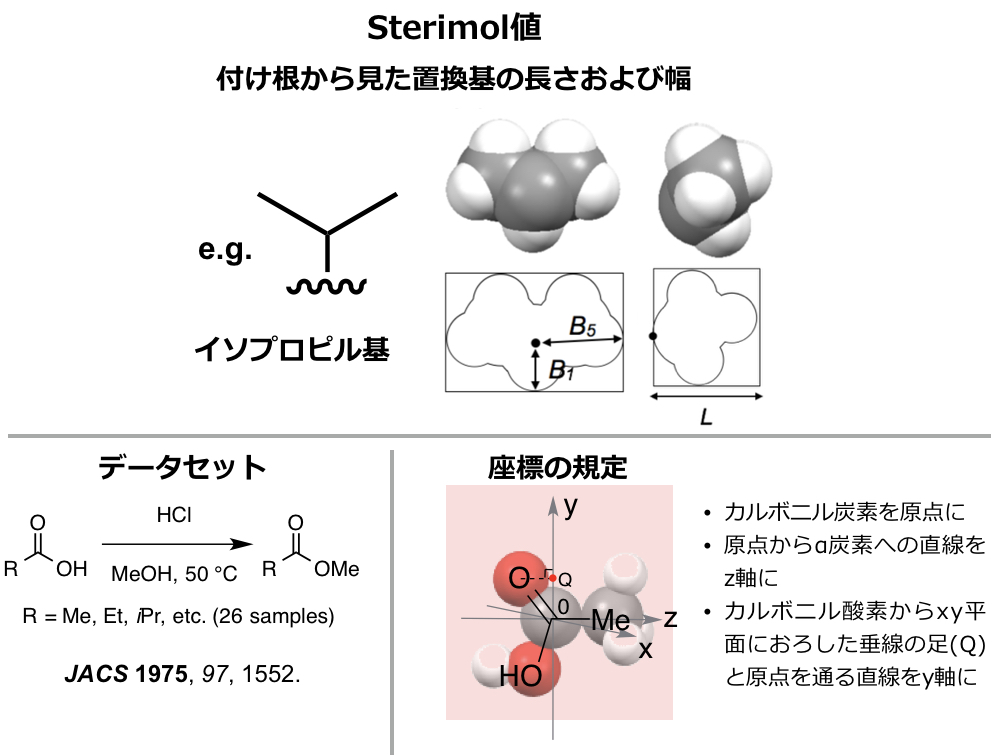

Sterimol parameter : 置換基の最大、最小の幅と置換基の長さからなる3次元の記述子

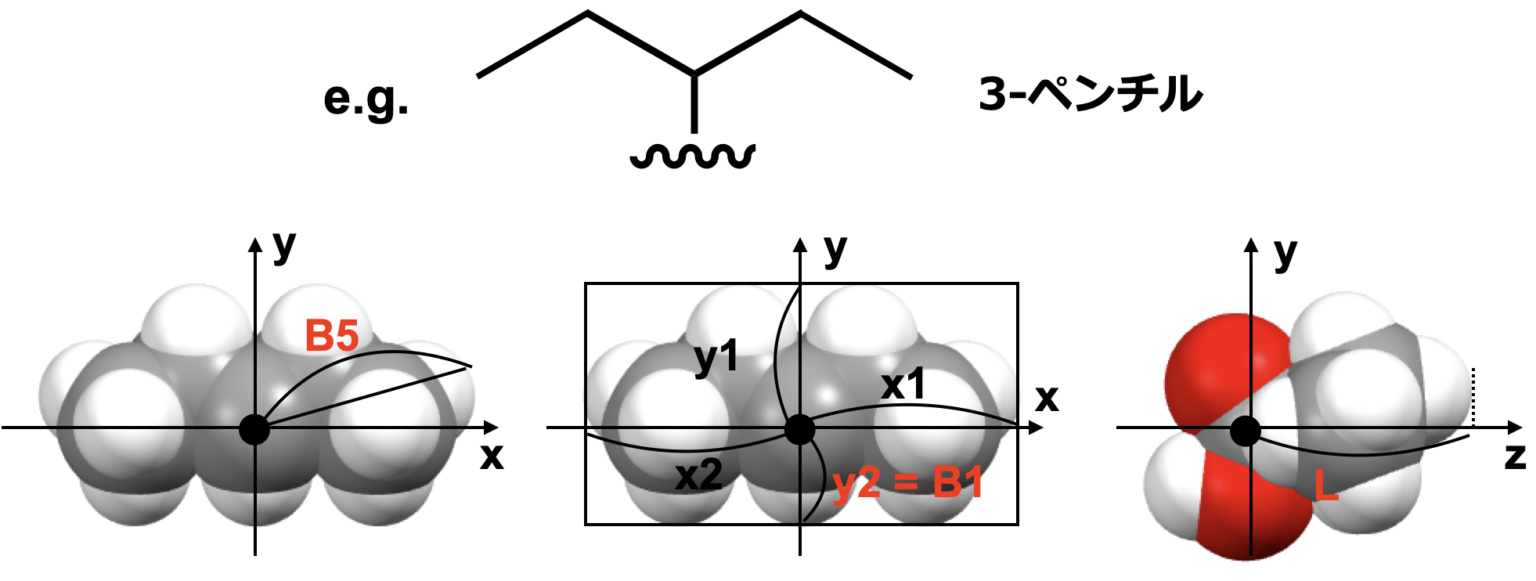

・　最大の幅は、単純にxy平面上に射影した置換基上の原子の原点からの距離を測り、その最大のもの(B5)

・　最小の幅は、x1,x2,y1,y2の長さのうち最も小さいもの(B1)

・　長さは原点から最も遠い水素原子のz座標(L)

### 長さ L を測る

In [14]:
# xyzファイルのパス
xyz_file_path = './MFA_Introduction-main/8th'

# 座標の読み込み
x, y, z = np.loadtxt(f'{xyz_file_path}/ChartonT1.xyz',
                      skiprows=2,
                      usecols=(1,2,3),
                      unpack=True)

# z座標のなかから最大値を抽出し、水素のファンデルワールス半径1.2Åを足す.
L = max(z) + 1.2
print("L: ", round(L, 2))

L:  3.08


### 最小および最大の幅を算出する (B1 および B5)

In [23]:
# xyzファイルから原子の文字列だけを読み込む
atoms = np.loadtxt(f'{xyz_file_path}/ChartonT1.xyz',
                      skiprows=2,
                      usecols=(0,),
                      unpack=True,
                      dtype='S3')

# 全原子数
number_atoms = len(atoms)
print(number_atoms)

8


In [25]:
# 水素原子の数を数える

# 方法-1 
count_H = np.sum(np.char.find(atoms,b'H') != -1)
print(count_H)

# 方法‐2
number_H = 0
for i in range(number_atoms):
    if atoms[i] == "H".encode():
        number_H = number_H + 1
print(number_H)

4
4


In [34]:
# xy平面上に射影した水素の原点からの距離、x座標、y座標を代入するためのゼロベクトル

B5 = np.zeros(number_H-1)
x_B1 = np.zeros(number_H-1)
y_B1 = np.zeros(number_H-1)

#xy平面上に射影した全原子の原点からの距離
distxy = np.sqrt(x**2 + y**2) #平方根を計算


B5 : 2.23


In [37]:
# カルボキシ基上の水素以外の水素の、xy平面上に射影した水素の原点からの距離、x座標、y座標を代入
# 今回のxyzファイルでは、カルボキシ基の水素は上から4つ目に統一

j = 0
for i in range(number_atoms):
    if i != 3 and atoms[i] == "H".encode():
        B5[j] = distxy[i]
        x_B1[j] = x[i]
        y_B1[j] = y[i]
        j = j + 1

B5 = max(B5) + 1.20
print ("B5:",round(B5,2))

B5: 2.23


In [42]:
# B1 の値を算出する.
B1_minus_x = B1_minus_y = B1_plus_x = B1_plus_y = 0.0
for i in range(j):
    if x_B1[i] <= 0 and B1_minus_x > x_B1[i]:
        B1_minus_x = x_B1[i]
    if y_B1[i] <= 0 and B1_minus_y > y_B1[i]:
        B1_minus_y = y_B1[i]
    if x_B1[i] >= 0 and B1_plus_x < x_B1[i]:
        B1_plus_x = x_B1[i]
    if y_B1[i] >= 0 and B1_plus_y < y_B1[i]:
        B1_plus_y = y_B1[i]

B1 = min(abs(B1_minus_x),
         abs(B1_minus_y),
         abs(B1_plus_x),
         abs(B1_plus_y)) + 1.20
print("B1 :", round(B1,2))

B1 : 1.73


In [48]:
from Sterimol_all import Sterimol

for mol in range(1,27):
    mol_name = xyz_file_path + "/ChartonT" + str(mol) + ".xyz"
    txt_name = "Sterimol_all.txt"
    Sterimol(mol_name,txt_name,mol)

./MFA_Introduction-main/8th/ChartonT1.xyz L: 3.08 B1: 1.73 B5: 2.23
./MFA_Introduction-main/8th/ChartonT2.xyz L: 4.4 B1: 1.78 B5: 3.36
./MFA_Introduction-main/8th/ChartonT3.xyz L: 5.25 B1: 1.78 B5: 3.6
./MFA_Introduction-main/8th/ChartonT4.xyz L: 7.41 B1: 1.78 B5: 5.0
./MFA_Introduction-main/8th/ChartonT5.xyz L: 4.36 B1: 2.53 B5: 3.39
./MFA_Introduction-main/8th/ChartonT6.xyz L: 5.38 B1: 1.98 B5: 4.59
./MFA_Introduction-main/8th/ChartonT7.xyz L: 4.37 B1: 2.31 B5: 4.63
./MFA_Introduction-main/8th/ChartonT8.xyz L: 6.64 B1: 1.82 B5: 4.76
./MFA_Introduction-main/8th/ChartonT9.xyz L: 4.33 B1: 2.96 B5: 3.39
./MFA_Introduction-main/8th/ChartonT10.xyz L: 4.31 B1: 2.22 B5: 4.69
./MFA_Introduction-main/8th/ChartonT11.xyz L: 4.51 B1: 2.22 B5: 7.23
./MFA_Introduction-main/8th/ChartonT12.xyz L: 4.42 B1: 3.21 B5: 5.98
./MFA_Introduction-main/8th/ChartonT13.xyz L: 5.03 B1: 1.78 B5: 6.3
./MFA_Introduction-main/8th/ChartonT14.xyz L: 6.94 B1: 1.78 B5: 7.59
./MFA_Introduction-main/8th/ChartonT15.xyz L: 9